In [7]:
%matplotlib inline

import numpy as np # linear algebra
olderr = np.seterr(all='ignore')
import pandas as pd # data processing
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

TestFlag = 1
# The root directory that contains all patient directories
INPUT_FOLDER = './ACDS/Red_1'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [8]:
#Load_scan(str): read a path of CT dataset, Load the slices into an array
#input:Path of CT dataset
#output:slices of CT data
def load_scan(path):
    slices = [pydicom.read_file(path +'/' + s, force= True) for s in os.listdir(path)]
    for i in range(len(slices)):
        try:
            slices[i].ImagePositionPatient
        except:
            slices.pop(i)
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

#unittest
if TestFlag == 1:
    #case1: test if Read_1 can be read correctly
    test1 = load_scan(INPUT_FOLDER)
    assert(len(red1)==164)

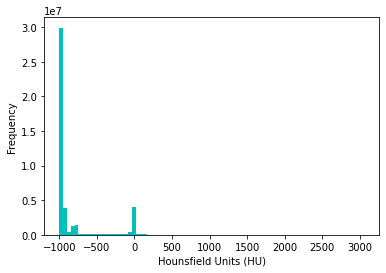

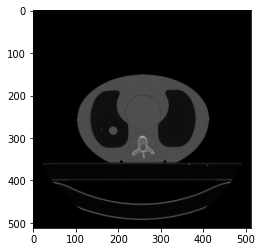

In [9]:
#get_pixels_hu(str):Convert to int16,then convert to HU units
#input:slices of CT data
#output:Hu values outside the fixed boundary are 0, and the slices are scaled


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    
    image = image.astype(np.int16)
 
    image[image == -2000] = 0
 
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

#unittest
if TestFlag == 1:
    first_patient = load_scan(INPUT_FOLDER)
    first_patient_pixels = get_pixels_hu(first_patient)
    plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()
    plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
    plt.show()

mid slices  82


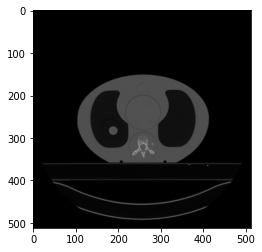

(512, 512)


In [10]:
# printSlide(str):read a path of CT dataset, Returns the image of the middle slices
#input:a path of CT dataset
#output:the image of the middle slices


def printSlide(patients):
    mid_slides = int(len(patients)/2)
    first_patient_pixel = get_pixels_hu(patients)
   
    print("mid slices ",mid_slides)
    plt.imshow(first_patient_pixel[mid_slides], cmap=plt.cm.gray)
    plt.show()
    print(first_patient_pixel[mid_slides].shape)
    return first_patient_pixel[mid_slides]

mid_slide = printSlide(first_patient)

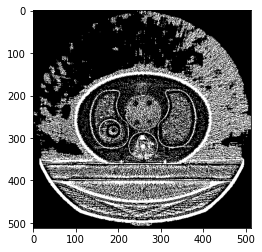

In [11]:
#adaptiveThreshold(str):Fill the rest of the outer outline of the image with gray and the middle body part of the image with black
#input:slices of CT data
#output:The external contour is a gray slice image

def adaptiveThreshold(slide):
    
    temp = slide
   
    gray_src = np.uint8(temp)
    gray_src = cv2.bitwise_not(gray_src)
    
    res = cv2.adaptiveThreshold(gray_src,125, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,-2)
    plt.imshow(res, cmap=plt.cm.gray)
    plt.show()
    return res

grayMap = adaptiveThreshold(mid_slide)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


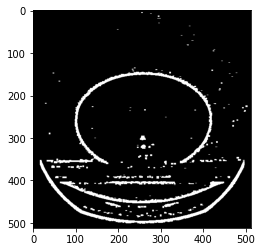

In [12]:
#morphology(str):Help find the outline of the boundary
def morphology(map):
    hline = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4), (-1, -1))
    vline = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 1), (-1, -1))
    temp = cv2.erode(map, hline)
    dst = cv2.dilate(temp, hline)
    dst = cv2.morphologyEx(map, cv2.MORPH_OPEN, hline)
    dst = cv2.morphologyEx(dst, cv2.MORPH_OPEN, vline)
    #dst = cv2.bitwise_not(dst)
    print(dst)
    plt.imshow(dst, cmap=plt.cm.gray)
    plt.show()
    return dst
    
morMap = morphology(grayMap)

In [13]:
#findCouch(str):Find the number of all couches
#input:The image after the contour is marked
#output:The number of the couch

def findCouch(map):
    rows = map.shape[0]
    cols = map.shape[1]
    for i in range(rows):
        count = 0
        for j in range(cols):
            if(map[i][j] > 0):
                count = count + 1

        if(count > 126):
            print(i)
            return i
    print("couch did not find")
    return rows

findCouch(morMap)

352


352

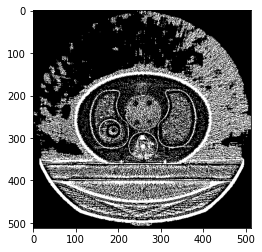

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


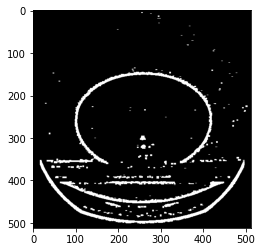

352


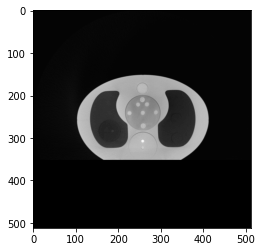

In [14]:
#CouchRemove(str):remove the couch
#input:slices of CT data
#output:slices which remove the couch


def CouchRemove(patients):
    mid_slides = int(len(patients)/2)
    first_patient_pixel = get_pixels_hu(patients)
    
    grayMap = adaptiveThreshold(first_patient_pixel[mid_slides])
    morMap = morphology(grayMap)
    couchPos = findCouch(morMap)
    removedSet = first_patient_pixel.copy()
    for i in range(len(first_patient_pixel)):
        tmp = first_patient_pixel[i]
        rows = tmp.shape[0]
        cols = tmp.shape[1]
        for r in range(couchPos, rows):
            for c in range(cols):
                removedSet[i][r][c] = -1024
    return removedSet
#unittest
if TestFlag == 1:
        removed = CouchRemove(first_patient)
        plt.imshow(removed[10], cmap=plt.cm.gray)
        plt.show()

In [15]:
# resample(str):Determine current pixel spacing,Resampling into slices of the same resolution
#input:Slices of different resolutions
#output:Slices of the same resolution

def resample(image, scan, new_spacing=[1,1,1]):
    
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    if( (spacing / new_spacing).all() ==0):
        resize_factor=1
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing
#unittest
if TestFlag == 1:
        pix_resampled, spacing = resample(removed , first_patient, [1,1,1])
print("Shape before resampling\t", removed.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (164, 512, 512)
Shape after resampling	 (328, 500, 500)


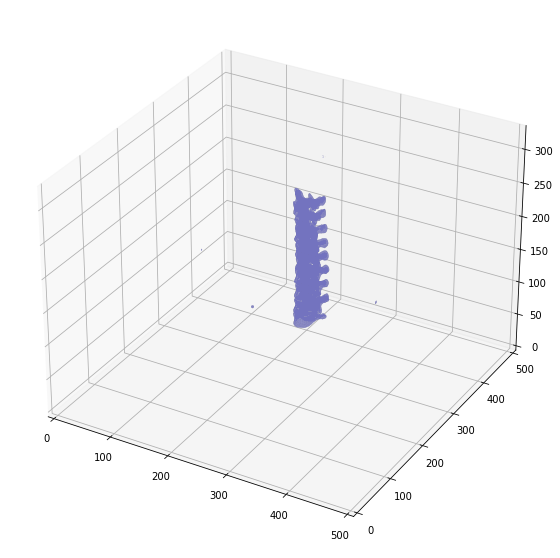

In [16]:
#plot_3d:Position the scan upright, Create an approximate grid of 3D objects using cubes
#input:Slices of the same resolution
#output:3D image

def plot_3d(image, threshold=-300):

   
    p = image.transpose(2,1,0)

    verts, faces,normals,values = measure.marching_cubes(p, threshold)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
#unittest
if TestFlag == 1:
    plt.show()
    plot_3d(pix_resampled, 400)